In [556]:
import pandas as pd
import numpy as np
import OpenBlender
import json
from datetime import datetime, timedelta
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from textblob import TextBlob
import re
import warnings
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
warnings.filterwarnings('ignore')

In [5]:
bitcoin_prices = pd.read_csv("crypto_prices_datasets/Bitcoin_prices.csv", header=0, skiprows=1)

In [6]:
df = bitcoin_prices[['date', 'open', 'close']]

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.642896e+12,2022-01-23 00:00:00,BTC/USDT,35071.42,35286.50,34944.00,35160.67,540.799770,1.900095e+07,15036.0
1,1.642810e+12,2022-01-22 00:00:00,BTC/USDT,36445.31,36835.22,34008.00,35071.42,90471.338961,3.207531e+09,2099978.0
2,1.642723e+12,2022-01-21 00:00:00,BTC/USDT,40680.92,41100.00,35440.45,36445.31,88860.891999,3.405502e+09,2092561.0
3,1.642637e+12,2022-01-20 00:00:00,BTC/USDT,41660.00,43505.00,40553.31,40680.91,42330.339530,1.784801e+09,1098761.0
4,1.642550e+12,2022-01-19 00:00:00,BTC/USDT,42352.12,42559.13,41138.56,41660.01,31685.721590,1.327478e+09,924528.0
...,...,...,...,...,...,...,...,...,...,...
1617,1.503274e+09,2017-08-21,BTC/USDT,4086.29,4119.62,3911.79,4016.00,685.120000,2.770592e+06,NaN
1618,1.503187e+09,2017-08-20,BTC/USDT,4139.98,4211.08,4032.62,4086.29,463.540000,1.915636e+06,NaN
1619,1.503101e+09,2017-08-19,BTC/USDT,4108.37,4184.69,3850.00,4139.98,371.150000,1.508239e+06,NaN
1620,1.503014e+09,2017-08-18,BTC/USDT,4285.08,4371.52,3938.77,4108.37,1178.070000,4.994494e+06,NaN


On our Bitcoin data, we have a column ‘price’ with the closing price of the day and ‘open’ with the opening price of the day.
We want to get the percentage difference from the closing price with respect to the opening price so we have a variable with that day’s performance.
To get this variable we will calculate the logarithmic difference between the close and open price.

In [8]:
df['log_diff'] = np.log(df['close']) - np.log(df['open'])
df

<ipython-input-8-467f9444fd52>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_diff'] = np.log(df['close']) - np.log(df['open'])


,date,open,close,log_diff
0,2022-01-23 00:00:00,35071.42,35160.67,0.002542
1,2022-01-22 00:00:00,36445.31,35071.42,-0.038426
2,2022-01-21 00:00:00,40680.92,36445.31,-0.109946
3,2022-01-20 00:00:00,41660.00,40680.91,-0.023782
4,2022-01-19 00:00:00,42352.12,41660.01,-0.016477
...,...,...,...,...
1617,2017-08-21,4086.29,4016.00,-0.017351
1618,2017-08-20,4139.98,4086.29,-0.013053
1619,2017-08-19,4108.37,4139.98,0.007665
1620,2017-08-18,4285.08,4108.37,-0.042113


Now, let’s generate our target variable by setting “1” if the performance was positive (log_diff > 0) and “0” if else.

In [9]:
df['price_change'] = [1 if log_diff > 0 else 0 for log_diff in df['log_diff']]

df['date'] = df['date'].apply(lambda x: x.split(' ')[0])
prices = df[['date', 'price_change']]
prices

<ipython-input-9-e0b29ad4b8fd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_change'] = [1 if log_diff > 0 else 0 for log_diff in df['log_diff']]
<ipython-input-9-e0b29ad4b8fd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(lambda x: x.split(' ')[0])


,date,price_change
0,2022-01-23,1
1,2022-01-22,0
2,2022-01-21,0
3,2022-01-20,0
4,2022-01-19,0
...,...,...
1617,2017-08-21,0
1618,2017-08-20,0
1619,2017-08-19,1
1620,2017-08-18,0


Simply put, our target will be to predict if the performance will be positive or not the following day (so we can make a potential trading decision).

In [583]:
bitcoin_tweets = pd.read_csv("crypto_tweets_datasets/Bitcoin_tweets.csv")

In [584]:
tweets = bitcoin_tweets[['date','text']]
tweets = tweets.loc[tweets['date'] > '2017-08-17'].loc[tweets['date'] < '2022-01-23'].reset_index(drop=True)
tweets['date'] = tweets['date'].apply(lambda x: x.split(' ')[0])
tweets

,date,text
0,2021-02-10,Blue Ridge Bank shares halted by NYSE after #b...
1,2021-02-10,"😎 Today, that's this #Thursday, we will do a ""..."
2,2021-02-10,"Guys evening, I have read this article about B..."
3,2021-02-10,$BTC A big chance in a billion! Price: \487264...
4,2021-02-10,This network is secured by 9 508 nodes as of t...
...,...,...
2126402,2022-01-13,I simply can't understand how they can't list ...
2126403,2022-01-13,#BTC is now at $43306.96
2126404,2022-01-13,"@feiprotocol \n\nSell #tribe $tribe , now \n..."
2126405,2022-01-13,#XMR - long alert 💰💵\n\nExchange : BINANCE...


In [12]:
print(len(tweets['date'].unique()))

105


In [13]:
df = tweets.merge(prices, on="date", how="inner")
df

,date,text,price_change
0,2021-02-10,Blue Ridge Bank shares halted by NYSE after #b...,0
1,2021-02-10,"😎 Today, that's this #Thursday, we will do a ""...",0
2,2021-02-10,"Guys evening, I have read this article about B...",0
3,2021-02-10,$BTC A big chance in a billion! Price: \487264...,0
4,2021-02-10,This network is secured by 9 508 nodes as of t...,0
...,...,...,...
2126402,2022-01-11,"Not too much, but 2022 be good to me baby! Bin...",1
2126403,2022-01-11,Will LUNA Price Bounce Again at .382 Fibonacci...,1
2126404,2022-01-11,Heads up! I'll be going live this Thursday at ...,1
2126405,2022-01-11,$LNR is going to be huge!!!! Kucoin and bitmar...,1


In [25]:
dates = df['date'].unique()
new_df = pd.DataFrame()

for date in dates:
    rows = df.loc[df['date'] == date]
    number_of_tweets = min(len(rows), 3000)
    new_df = pd.concat([new_df, rows.sample(number_of_tweets)])

new_df.reset_index(drop=True)

,date,text,price_change
0,2021-02-10,@Reuters Right on... $XRP is literally 1000x b...,0
1,2021-02-10,Post #312 Price history of bitcoin\n\nLOL. If ...,0
2,2021-02-10,🤝 Follow me on @betfury_io. Let's hunt for Bit...,0
3,2021-02-10,MATIC broke ATH after 2 years 🚀. Big move inco...,0
4,2021-02-10,@herrerabreda @nichegamer Right here w/ @Binan...,0
...,...,...,...
299260,2022-01-11,the strongest bullish signal flashed for #Bitc...,1
299261,2022-01-11,“A profound idea can only propagate so quickly...,1
299262,2022-01-11,#bitcoin #FinancialFreedom #BTC 🩰learning abou...,1
299263,2022-01-11,🚨🚨 Tuesday Tide Report 🚨🚨 \n\n#Bitcoin #Crypto...,1


In [26]:
symbols_set = {'!','@', '#', '₿', '$', '&', '%', '*', '-', '_', '+', 'http'}

def noise_cleaning_and_tokenizing(row):
    new_row = []
    row = row.replace('\n', ' ')
    words = row.split(' ')
    for word in words:
        if not word.startswith(tuple(symbols_set)):
            new_row.append(word.rstrip('.…').lower())
    return nltk.word_tokenize(" ".join(new_row))
  

def clear_words(row):
    new_row = []
    for word in row:
        res = re.sub(r'[^\w\s]', '', word)
        if res != '' and not res.isnumeric():
            new_row.append(res)
    return new_row
            

def remove_stopwords(row):
    new_row = []
    for word in row:
        if not word in stopwords.words('english'):
            new_row.append(word)
    return new_row


def lemitization(row):
    wnet = WordNetLemmatizer()
    new_row = []
    for word in row:
        new_row.append(wnet.lemmatize(word))
    return new_row
    

def data_preprocessing(row):
    res = noise_cleaning_and_tokenizing(row)
    res = clear_words(res)
    res = remove_stopwords(res)
    res = lemitization(res)
    return res


def get_polarity(row):
    content = " ".join(row)
    return TextBlob(content).sentiment.polarity


In [28]:
new_df['extracted_text'] = new_df['text'].apply(lambda row: data_preprocessing(row))
new_df = new_df[new_df['extracted_text'].str.len() > 0]
new_df['sentiment'] = new_df['extracted_text'].apply(lambda row: get_polarity(row))

In [31]:
new_df.to_csv('generated_datasets/bitcoin_sentiment_vs_price_change.csv', index=False)

In [33]:
new_df.reset_index(drop=True)

,date,text,price_change,extracted_text,sentiment
0,2021-02-10,@Reuters Right on... $XRP is literally 1000x b...,0,"[right, literally, 1000x, better, sec, fast, p...",0.257143
1,2021-02-10,Post #312 Price history of bitcoin\n\nLOL. If ...,0,"[post, price, history, bitcoin, lol, knew, bit...",0.800000
2,2021-02-10,🤝 Follow me on @betfury_io. Let's hunt for Bit...,0,"[follow, let, hunt, bitcoins, together, get, e...",0.300000
3,2021-02-10,MATIC broke ATH after 2 years 🚀. Big move inco...,0,"[matic, broke, ath, year, big, move, incoming,...",0.000000
4,2021-02-10,@herrerabreda @nichegamer Right here w/ @Binan...,0,"[right, w, referral, code]",0.285714
...,...,...,...,...,...
295970,2022-01-11,the strongest bullish signal flashed for #Bitc...,1,"[strongest, bullish, signal, flashed, trend, r...",0.377778
295971,2022-01-11,“A profound idea can only propagate so quickly...,1,"[profound, idea, propagate, quickly, collectiv...",0.138889
295972,2022-01-11,#bitcoin #FinancialFreedom #BTC 🩰learning abou...,1,"[learning, future, know]",0.000000
295973,2022-01-11,🚨🚨 Tuesday Tide Report 🚨🚨 \n\n#Bitcoin #Crypto...,1,"[tuesday, tide, report]",0.000000


In [106]:
new_df[['date', 'text', 'extracted_text', 'sentiment']].sample(15)

,date,text,extracted_text,sentiment
301069,2021-07-04,$Rally is 15bn token supply ? Are you fucking ...,"[15bn, token, supply, fucking, shutting]",-0.600000
1834646,2021-11-18,#Dogecoin #memes #crypto #cryptocurrency #doge...,"[forex, signal, available, forexworld843, gmai...",0.400000
2708,2021-02-10,#Centralbanks always use the same lies.\n\nPeo...,"[always, use, lie, people, care, le, le, use]",0.000000
478524,2021-07-20,Prominent #Bitcoin maximalist Max Keiser belie...,"[prominent, maximalist, max, keiser, belief, l...",0.250000
41456,2021-02-22,Absolute chaos today. Hope all you cryptonites...,"[absolute, chaos, today, hope, cryptonites, ke...",0.316667
116769,2021-05-27,@alexisolinart Happiness is... A Warm NFT Coll...,"[happiness, warm, nft, collection, http, tcouq...",0.650000
111600,2021-05-28,"Bitcoin: $35,024.27\n -10.15% (-$3955.77)\nHig...","[bitcoin, high, low, volume]",0.080000
18074,2021-02-06,"FORGET #BITCOIN, #ALTCOINS are MOVING! With ht...","[forget, moving, analyze, volumeprice, movin]",0.000000
12133,2021-02-08,"""This is $TSLA and @elonmusk diving into the d...","[diving, deep, end, pool, crypto, something, r...",0.000000
1419450,2021-10-21,What a load of crap! Are they still trying to ...,"[load, crap, still, trying, fool, u, instituti...",-0.750000


In [323]:
grouped_df = new_df[['date','sentiment', 'price_change']].groupby('date').mean()

grouped_df['price_change'] = grouped_df['price_change'].apply(lambda x: int(x))
grouped_df

,sentiment,price_change
date,,
2021-02-05,0.090009,1
2021-02-06,0.090390,1
2021-02-07,0.105510,0
2021-02-08,0.100273,1
2021-02-09,0.100581,1
...,...,...
2021-12-30,0.134369,1
2022-01-11,0.149601,1
2022-01-12,0.172582,1


In [328]:
median = new_df[['date','sentiment']].groupby('date').median()
median.rename(columns = {'sentiment': 'sentiment_median'}, inplace = True)
grouped_df = grouped_df.merge(median, on="date", how="inner")

In [329]:
# calculate the total amount of negative/positive/neutral tweets for the whole dataset

negative_counts = 0
positive_counts = 0
neutral_counts = 0

for index, row in new_df.iterrows():
    sentiment = row['sentiment']
    if sentiment > 0:
        positive_counts += 1
    elif sentiment < 0:
        negative_counts += 1
    else:
        neutral_counts += 1
        
total_tweets = positive_counts + negative_counts + neutral_counts

In [330]:
print("The total amount of negative/positive/neutral tweets for the whole dataset")
print(f'Positive: {positive_counts} tweets ({round(positive_counts/total_tweets, 3)}%)')
print(f'Negative: {negative_counts} tweets ({round(negative_counts/total_tweets, 3)}%)')
print(f'Neutral: {neutral_counts} tweets ({round(neutral_counts/total_tweets, 3)}%)')
print(f'Total: {total_tweets} tweets')

The total amount of negative/positive/neutral tweets for the whole dataset
Positive: 137363 tweets (0.464%)
Negative: 31199 tweets (0.105%)
Neutral: 127413 tweets (0.43%)
Total: 295975 tweets


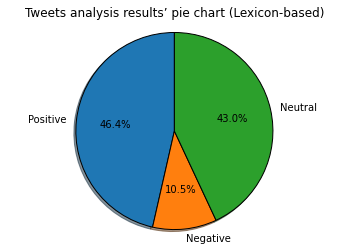

In [579]:
labels = ['Positive', 'Negative', 'Neutral']
sizes = [round(positive_counts/total_tweets, 3),round(negative_counts/total_tweets, 3), round(neutral_counts/total_tweets, 3)]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=list(mcolors.TABLEAU_COLORS),
        shadow=True, startangle=90,  wedgeprops={'edgecolor': 'black'})
ax1.set_title('Tweets analysis results’ pie chart (Lexicon-based)')
ax1.axis('equal')
plt.show()

In [581]:
# add new features to the final data frame

def get_sentiment_class(row): 
    treshold = 0
    sentiment = row['sentiment']
    if sentiment > treshold:
        return 1
    elif sentiment < -treshold:
        return -1
    else:
        return 0


def add_sentiment_columns():
    final_df["positive_tweets_percent"] = np.nan
    final_df["negative_tweets_percent"] = np.nan
    final_df["neutral_tweets_percent"] = np.nan
    
    dates = new_df['date'].unique()

    for date in dates:
        rows = new_df.loc[new_df['date'] == date]
        
        negative_counts = 0
        positive_counts = 0
        neutral_counts = 0

        for index, row in rows.iterrows():
            sentiment = row['sentiment']
            treshold = 0
            if sentiment > treshold:
                positive_counts += 1
            elif sentiment < -treshold:
                negative_counts += 1
            else:
                neutral_counts += 1

        total_tweets = positive_counts + negative_counts + neutral_counts
        positive_percent = positive_counts/total_tweets
        negative_percent = negative_counts/total_tweets
        neutral_percent = neutral_counts/total_tweets
        
        final_df.at[date,'positive_tweets_percent'] = round(positive_percent, 4)
        final_df.at[date,'negative_tweets_percent'] = round(negative_percent, 4)
        final_df.at[date,'neutral_tweets_percent'] = round(neutral_percent, 4)


final_df = grouped_df
final_df['sentiment_class'] = grouped_df.apply(lambda row: get_sentiment_class(row), axis=1)
add_sentiment_columns()

final_df = final_df[['sentiment', 'sentiment_median', 'sentiment_class', 'positive_tweets_percent', 'negative_tweets_percent', 'neutral_tweets_percent', 'price_change']]
final_df.rename(columns = {'sentiment': 'sentiment_mean', 'price_change': 'bitcoin_price_change'}, inplace = True)
final_df_bitcoin = final_df


In [582]:
final_df.to_csv('generated_datasets/bitcoin_sentiment_vs_price_change_grouped.csv', index=False)

In [516]:
final_df

,sentiment_mean,sentiment_median,sentiment_class,positive_tweets_percent,negative_tweets_percent,neutral_tweets_percent,bitcoin_price_change
date,,,,,,,
2021-02-05,0.090009,0.000000,1,0.3580,0.0910,0.5509,1
2021-02-06,0.090390,0.000000,1,0.3496,0.0744,0.5760,1
2021-02-07,0.105510,0.000000,1,0.3774,0.0682,0.5544,0
2021-02-08,0.100273,0.000000,1,0.3756,0.0795,0.5450,1
2021-02-09,0.100581,0.000000,1,0.3857,0.0761,0.5382,1
...,...,...,...,...,...,...,...
2021-12-30,0.134369,0.000000,1,0.4940,0.1069,0.3992,1
2022-01-11,0.149601,0.041667,1,0.5201,0.0997,0.3802,1
2022-01-12,0.172582,0.107273,1,0.5682,0.0821,0.3497,1


In [580]:
def move_date_day_back(date_string):
    date = datetime.strptime(date_string, '%Y-%m-%d')
    return (date + timedelta(days=-1)).strftime('%Y-%m-%d')


def get_crypto_price_change(file, name):
    prices = pd.read_csv("crypto_prices_datasets/" +file, header=0, skiprows=1)
    prices = prices[['date', 'open', 'close']]
    prices['log_diff'] = np.log(prices['close']) - np.log(prices['open'])
    prices['price_change'] = [1 if log_diff > 0 else 0 for log_diff in prices['log_diff']]
    prices['date'] = prices['date'].apply(lambda x: move_date_day_back(x.split(' ')[0]))
    prices = prices[['date', 'price_change']]
    prices = prices.set_index('date')
    
    prices = final_df.merge(prices, on="date", how="inner")
    prices.drop(columns=['bitcoin_price_change'], inplace=True)
    prices.rename(columns = {'price_change': name + '_price_change'}, inplace = True)

    return prices

final_df_bitcoin = get_crypto_price_change("Bitcoin_prices.csv", 'bitcoin')
final_df_ethernum = get_crypto_price_change("Ethernum_prices.csv", 'ethernum')
final_df_binancecoin = get_crypto_price_change("Binancecoin_prices.csv", 'binancecoin')
final_df_cardano = get_crypto_price_change("Cardano_prices.csv", 'cardano')
final_df_chainlink = get_crypto_price_change("Chainlink_prices.csv", 'chainlink')
final_df_litecoin = get_crypto_price_change("Litecoin_prices.csv", 'litecoin')
final_df_neo = get_crypto_price_change("Neo_prices.csv", 'neo')
final_df_neo

,sentiment_mean,sentiment_median,sentiment_class,positive_tweets_percent,negative_tweets_percent,neutral_tweets_percent,neo_price_change
date,,,,,,,
2021-02-05,0.090009,0.000000,1,0.3580,0.0910,0.5509,0
2021-02-06,0.090390,0.000000,1,0.3496,0.0744,0.5760,0
2021-02-07,0.105510,0.000000,1,0.3774,0.0682,0.5544,1
2021-02-08,0.100273,0.000000,1,0.3756,0.0795,0.5450,1
2021-02-09,0.100581,0.000000,1,0.3857,0.0761,0.5382,1
...,...,...,...,...,...,...,...
2021-12-30,0.134369,0.000000,1,0.4940,0.1069,0.3992,0
2022-01-11,0.149601,0.041667,1,0.5201,0.0997,0.3802,1
2022-01-12,0.172582,0.107273,1,0.5682,0.0821,0.3497,0


# Sentiment analysis by supervised approach - classification

In [595]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

In [596]:
def print_score(y_test, y_pred):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)
    FP = FP.astype(float).sum()
    FN = FN.astype(float).sum()
    TP = TP.astype(float).sum()
    TN = TN.astype(float).sum()
    accuracy = ((TP + TN)/(TP + TN + FP + FN)) * 100
    return accuracy


def classifier(dataset, classifier):
    target_column_name = dataset.columns[-1]
    target = dataset[target_column_name]
    data = dataset.drop(columns=target_column_name)
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=42)
    model = classifier.fit(X_train, y_train)
    test_score = model.score(X_test, y_test)
    predict = classifier.predict(X_test)
    accuracy = print_score(y_test, predict)
    return accuracy

In [597]:
def naive_bayes(dataset):
    return classifier(dataset, GaussianNB())

In [598]:
def random_forest(dataset):
    results = []
    for i in range(50):
        results.append(classifier(dataset, RandomForestClassifier(n_estimators=100, max_depth=20)))

    return round(np.array(results).mean(), 2)

In [599]:
def ada_boost(dataset):
    results = []
    for i in range(50):
        results.append(classifier(dataset, AdaBoostClassifier(n_estimators=40)))

    return round(np.array(results).mean(), 2)

In [600]:
def k_nearest_neighbours(dataset):
    results = []
    for i in range(50):
        results.append(classifier(dataset, KNeighborsClassifier()))

    return round(np.array(results).mean(), 2)

In [601]:
def multi_layer_perceptron(dataset):
    results = []
    for i in range(50):
        results.append(classifier(dataset, MLPClassifier(solver="sgd")))

    return round(np.array(results).mean(), 2)

In [602]:
def svm_linear(dataset):
    return classifier(dataset, LinearSVC(random_state=0, tol=1e-05, dual=False, C=1))

Classification for cryptocurrencies

In [603]:
cryptocurrencies_datasets = {
    'Bitcoin': final_df_bitcoin,
    'Ethernum': final_df_ethernum,
    'Binancecoin': final_df_binancecoin,
    'Cardano': final_df_cardano,
    'Chainlink': final_df_chainlink,
    'Litecoin': final_df_litecoin,
    'Neo': final_df_neo}

In [604]:
accuracies = pd.DataFrame(
    index=list(cryptocurrencies_datasets.keys()),
    columns=['naive_bayes', 'random_forest', 'ada_boost', 'k_nearest_neighbours', 'multi_layer_perceptron', 'svm_linear',])

In [605]:
for crypto, dataset in cryptocurrencies_datasets.items():
    accuracies.at[crypto,'naive_bayes'] = naive_bayes(dataset)
    accuracies.at[crypto,'random_forest'] = random_forest(dataset)
    accuracies.at[crypto,'ada_boost'] = ada_boost(dataset)
    accuracies.at[crypto,'k_nearest_neighbours'] = k_nearest_neighbours(dataset)
    accuracies.at[crypto,'multi_layer_perceptron'] = multi_layer_perceptron(dataset)
    accuracies.at[crypto,'svm_linear'] = svm_linear(dataset)

In [606]:
accuracies.loc['Average'] = round(accuracies.mean(axis=0), 2)
accuracies['Average'] = round(accuracies.mean(axis=1), 2)
accuracies

,naive_bayes,random_forest,ada_boost,k_nearest_neighbours,multi_layer_perceptron,svm_linear,Average
Bitcoin,59.375,57.62,49.94,50.0,49.5,50.0,52.74
Ethernum,59.375,45.88,46.88,62.5,65.62,65.625,57.65
Binancecoin,65.625,59.0,62.5,68.75,68.75,68.75,65.56
Cardano,59.375,56.31,53.12,59.38,65.62,65.625,59.90
Chainlink,59.375,45.44,53.12,62.5,65.62,65.625,58.61
Litecoin,50.0,50.62,56.25,68.75,52.38,59.375,56.23
Neo,62.5,56.62,59.38,65.62,68.75,65.625,63.08
Average,59.38,53.07,54.46,62.5,62.32,62.95,59.11


# Data Visualisation

In [607]:
def barchart(data, dataset_name):
    fig, ax = plt.subplots()
    x_pos = np.arange(len(data)-1)
    values = []
    for value in data[:-1]:
        values.append(value)
    
    labels = list(accuracies.columns)[:-1]

    ax.bar(x_pos, values, align='center', color=mcolors.TABLEAU_COLORS, alpha=0.5, capsize=10)
    ax.set_ylabel('Accuracy')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)
    ax.set_title(f'Accuracies of algorithms for {dataset_name}')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False)
    fig.set_size_inches(18.5, 10.5)
    plt.savefig('graphs/' + dataset_name + '.png',dpi=400)
    plt.show()

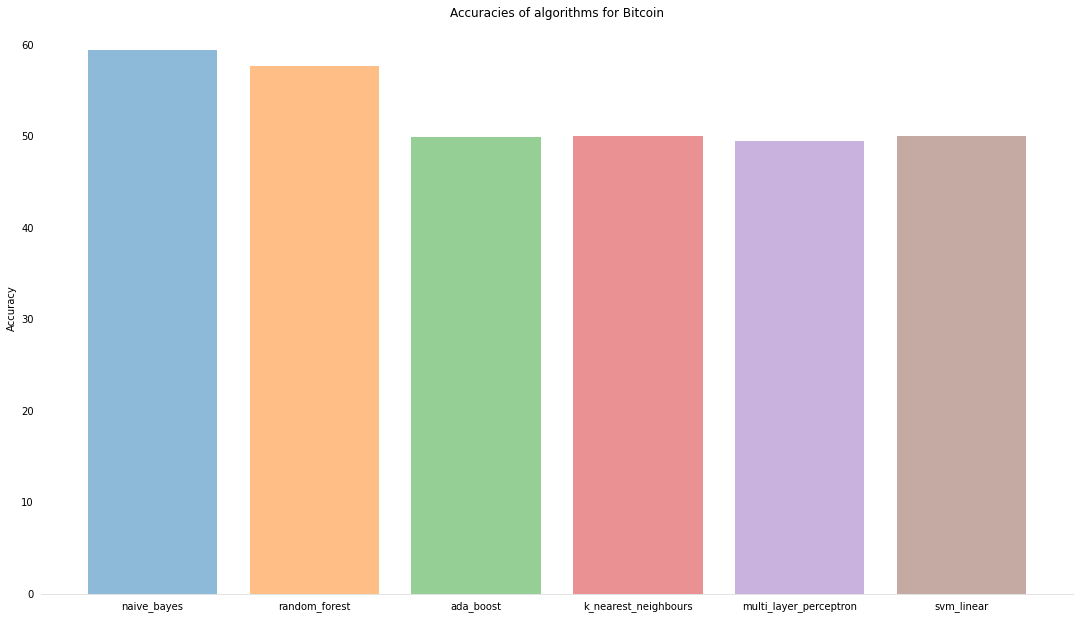

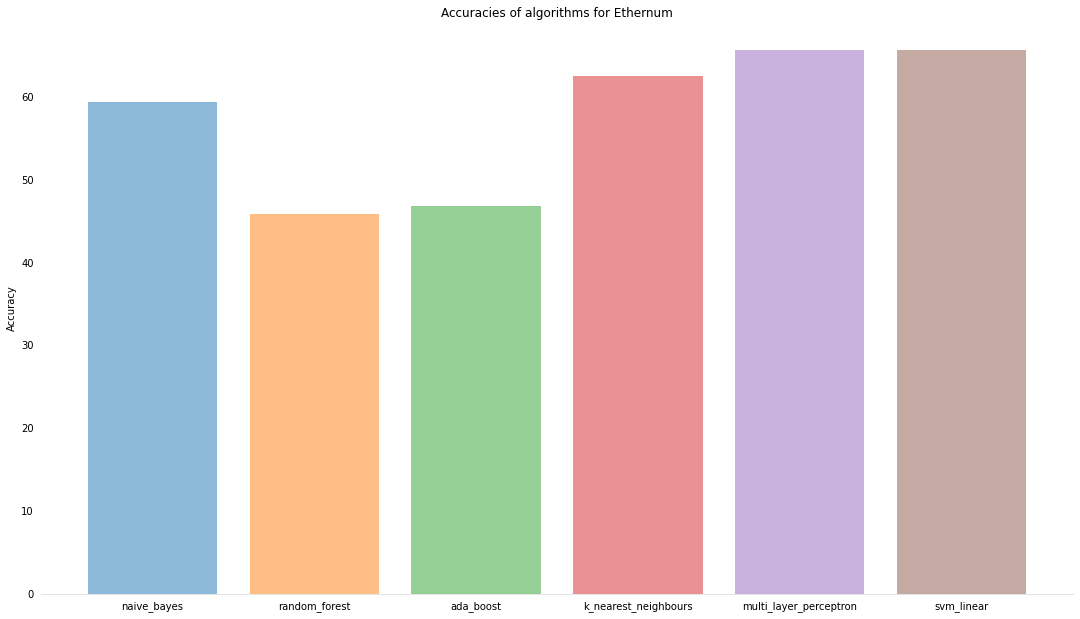

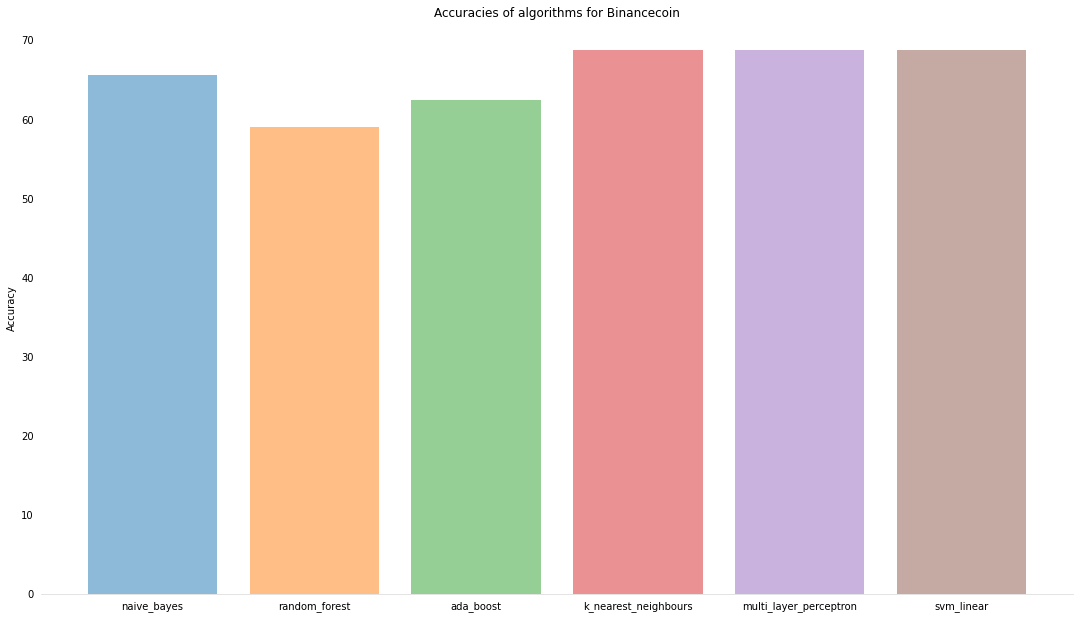

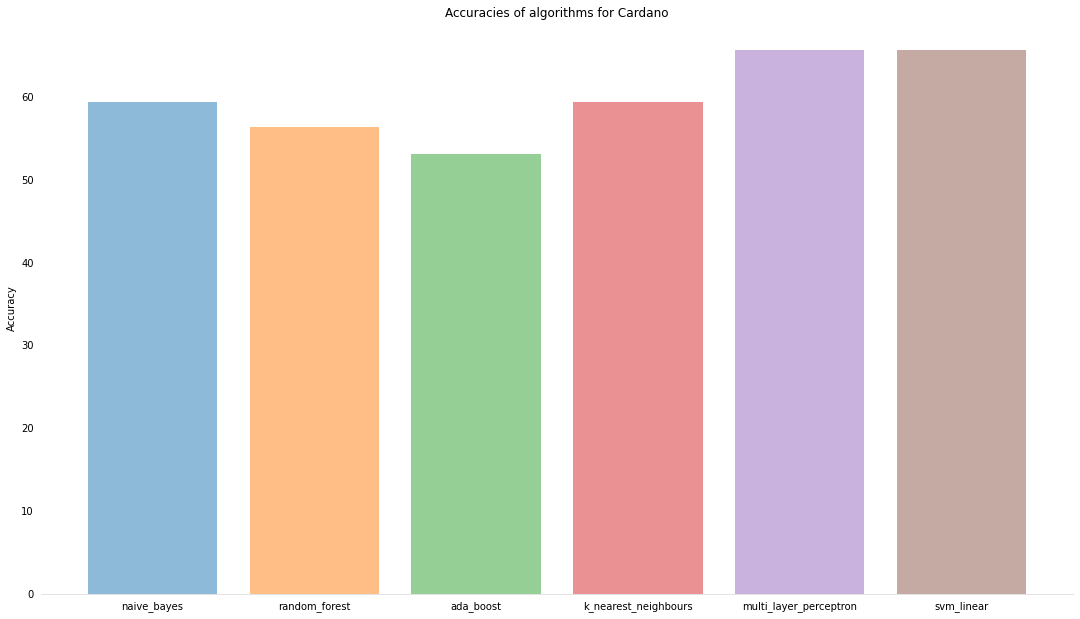

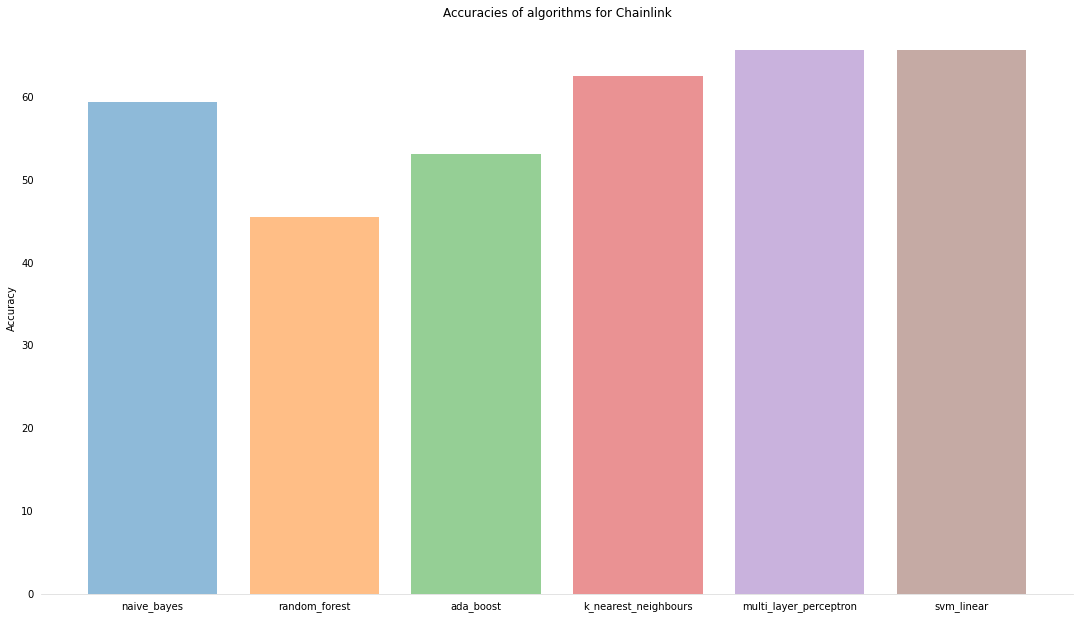

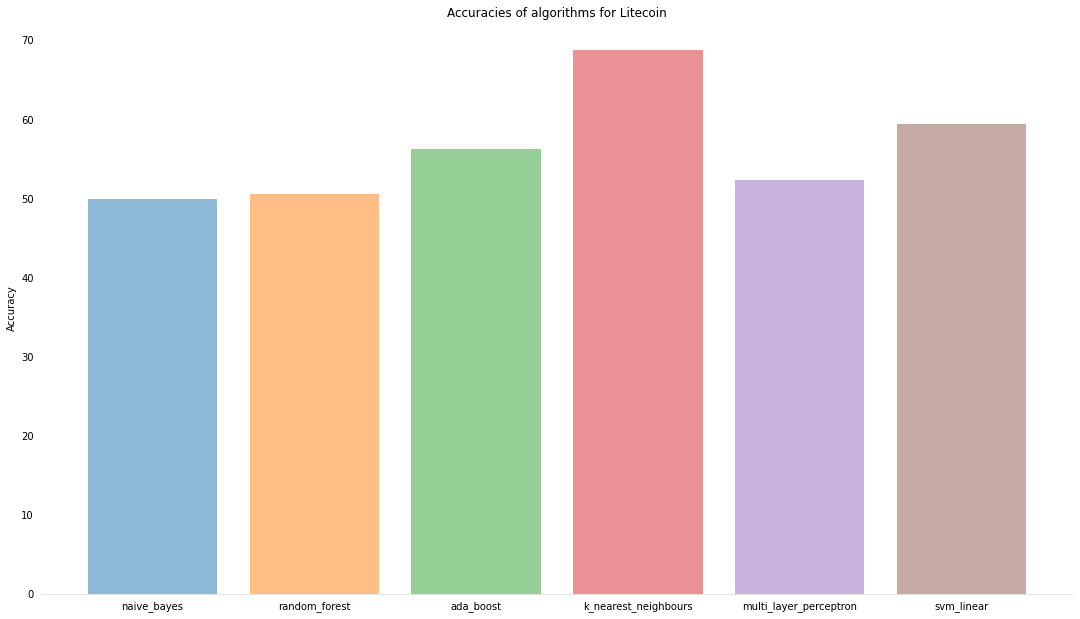

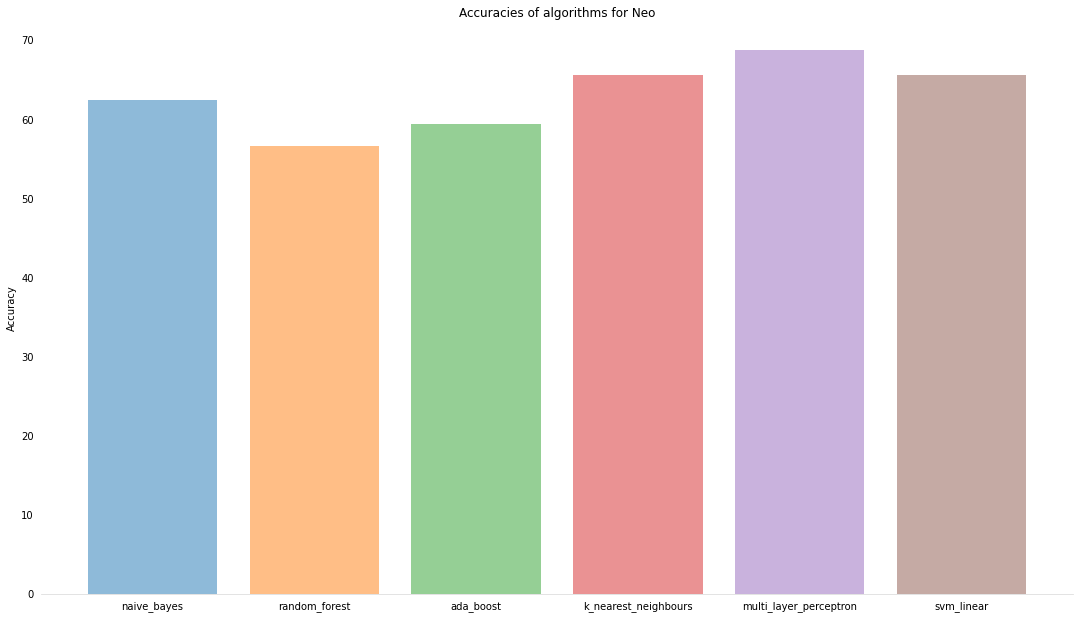

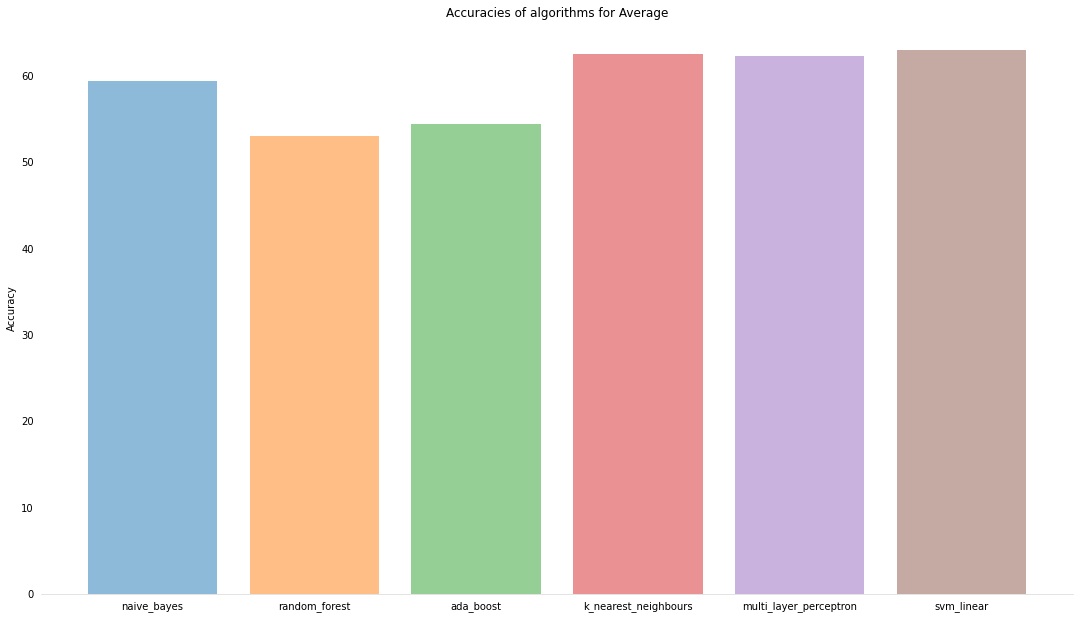

In [608]:
for index, row in accuracies.iterrows():
    barchart(row, str(index))